In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import cos, log, sin # Untuk mendukung perhitungan pada Positional Embedding
from math import sqrt
from typing import Optional # Untuk keperluan pemberian nilai default pada status masking
import copy # Untuk keperluan replikasi pada encoder maupun decoder block

In [2]:
class Embedding(nn.Module):
    """
    Kelas menghasilkan representasi numerik dari indeks kata dalam vocab

    Attribut:
        dimensi_embedding (int): dimensi embedding yang digunakan untuk representasi
                                setiap dari kata
        embed (nn.Embedding): embedding PyTorch yang mengonversi indeks kata
                                menjadi vektor embedding

    Metode:
        forward(x: torch.Tensor) -> torch.Tensor:
            hitung representasi embedding dari input tensor dengan skala
            akar kuadrat dari dimensi embedding
    """

    def __init__(self, ukuran_vocab: int, dimensi_embedding: int) -> None:
        """
        Inisialisasi lapisan embedding

        Parameter:
            ukuran_vocab (int): ukuran vocab (jumlah kata unik dalam dataset)
            dimensi_embedding (int): dimensi embedding untuk setiap dari kata
        """
        super(Embedding, self).__init__()
        self.dimensi_embedding = dimensi_embedding
        self.embed = nn.Embedding(
            num_embeddings=ukuran_vocab, embedding_dim=dimensi_embedding
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Fungsi untuk melakukan forward pass untuk result representasi embedding dari input
        tensor

        Parameter:
            x (torch.Tensor): tensor yang berisi indeks kata dengan
                                shape (batch_size, sequence_length)

        Return:
            torch.Tensor: representasi embedding dari input tensor dengan shape
                            (batch_size, sequence_length, dimensi_embedding)
        """
        output = self.embed(x) * sqrt(self.dimensi_embedding)
        return output

In [3]:
class PositionalEncoding(nn.Module):
    """
    Kelas untuk menambahkan positional encoding ke representasi embedding
    positional encoding akan membantu model akan memahami urutan dari token dalam sekuens

    Attribut:
        dimensi_embedding (int): dimensi embedding yang digunakan
        dropout (nn.Dropout): lapisan dropout untuk regularisasi
        pe (torch.Tensor): buffer yang menyimpan positional encoding untuk semua posisi

    Return:
        pe_sin(position: int, i: int) -> float: menghitung nilai sinus untuk positional
                                            encoding pada posisi tertentu
        pe_cos(position: int, i: int) -> float: menghitung cosinus positional encoding
                                            pada posisi tertentu
        forward(x: torch.Tensor) -> torch.Tensor: tambahkan positional encoding ke input
                                            tenso dan menerapkan dropout
    """

    def __init__(
        self,
        dimensi_embedding: int,
        panjang_maksimal_sekuens: int = 5_000,
        dropout: float = 0.1,
    ) -> None:
        """
        Inisialisasi lapisan dari positional encoding
        """
        super(PositionalEncoding, self).__init__()
        self.dimensi_embedding = dimensi_embedding
        self.dropout = nn.Dropout(p=dropout)

        positional_encoding = torch.zeros(
            panjang_maksimal_sekuens, self.dimensi_embedding
        )
        position = torch.arange(0, panjang_maksimal_sekuens).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, dimensi_embedding, 2) * (log(10_000.0) / dimensi_embedding)
        )

        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)

        pe = positional_encoding.unsqueeze(0)
        self.register_buffer("pe", pe)

    def pe_sin(self, position: int, i: int) -> float:
        """
        Menghitung komponen sinus dari positionla encoding untuk posisi dan dimensi
        tertentu

        Parameter:
            position (int): posisi token dalam urutan (dimulai dari 0)
            i (int): indeks dimensi dalam vektor embedding (dimulai dari 0)

        Return:
            (float): nilai sinus hasil perhitungan positional encoding

        Rumus:
            sin (position / (10_000 ** (2i / d_model)))
            - d_model = self.dimensi_embedding (dimensi vektor embedding)
            - 10_000 = konstanta dasar untuk skala eksponensial
            - 2i = memastikan pola periodik yang berbeda untuk setiap dari dimensi

        Informasi tambahan:
            - implementasi ini sesuai dari paper "attention is all you need"
                (Vaswani et al., 2017)
            - untuk dimensi genap, menggunakan sin; untuk ganjil maka gunakan cos
        """
        return sin(position / (10_000 ** ((2 * i) / self.dimensi_embedding)))

    def pe_cos(self, position: int, i: int) -> float:
        """
        Mnghitung komponen kosinus dari positional encoding untuk posisi dan dimensi tertentu

        Parameter:
            position (int): posisi token dalam urutan (dimulai dari 0)
            i (int): indeks dimensi dalam vektor embedding (dimulai dari 0)

        Return:
            float: nilai kosinus hasil dari perhitungan positional encoding

        Rumus:
            cos (position / (10_000 ** (2i / d_model)))
            - d_model = self.dimensi_embedding (dimensi vektor embedding)
            - 10_000 = kostanta dasar untuk skala eksponensial
            - 2i = memastikan pola periodik yang berbeda untuk setiap dimensi

        Informasi tambahan:
            - merupakan pasangan dari pe_sin() untuk membetuk positional encoding lengkap
            - nilai cos ini diambil untuk dimensi ganjil, sin untuk genap dalam implementasi
              standar
        """
        return cos(position / (10_000 ** ((2 * i) / self.dimensi_embedding)))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Melakuan operasi forward pass dengan menambahkan positional encoding ke input

        Parameter:
            x (torch.Tensor): input tensor dengan bentuk (batch_size, sequence_length, dimensi_embedding)

        Return:
            torch.Tensor: tensor hasil penambahan positional encoding dengan dropout

        Proses:
            - mengambil positional encoding yang telah dihitung sebelumnya
            - melakukan slicing sesuai panjang sequence input
            - nonaktifkan gradient untuk positional encoding
            - menambahkan positional encoding ke input tensor
            - menerapkan dropout untuk regularisasi

        Informasi tambahan:
            - positional encoding bersifat fixed (tidak dipelajari selama training)
            - dropout diterapkan setelah penambahan positional encoding
            - menggunakan broadcasting untuk menyesuaikan panjang sequence
        """
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [4]:
if __name__ == "__main__":
    ukuran_vocab: int = 1000
    dimensi_embedding: int = 512
    panjang_maksimal_sekuens: int = 20
    ukuran_batch: int = 2
    panjang_sekuens: int = 10

    input_sekuens = torch.randint(0, ukuran_vocab, (ukuran_batch, panjang_sekuens))
    print("input sekuens (indeks kata)")
    print(input_sekuens)

    embedding_layer = Embedding(
        ukuran_vocab=ukuran_vocab, dimensi_embedding=dimensi_embedding
    )
    positional_encoding_layer = PositionalEncoding(
        dimensi_embedding=dimensi_embedding,
        panjang_maksimal_sekuens=panjang_maksimal_sekuens,
    )

    embed_output = embedding_layer(input_sekuens)
    print("Output dari embedding (representasi numerik): ")
    print(embed_output.shape)

    output_dengan_positional_encoding = positional_encoding_layer(embed_output)
    print("output dengan positional encoding: ")
    print(output_dengan_positional_encoding.shape)

    print("nilai output dengan positional encoding:")
    print(output_dengan_positional_encoding[0, :2, :5])

input sekuens (indeks kata)
tensor([[449, 474, 942, 285, 363,  28, 508, 110, 337, 126],
        [204, 446, 195, 421, 678, 977, 529, 581, 214,  74]])
Output dari embedding (representasi numerik): 
torch.Size([2, 10, 512])
output dengan positional encoding: 
torch.Size([2, 10, 512])
nilai output dengan positional encoding:
tensor([[ -0.0000, -21.8364,  37.4246,  62.0792,  42.7351],
        [  0.0000,  -8.7761, -11.3518, -26.1334,  16.6734]],
       grad_fn=<SliceBackward0>)


In [5]:
class MultiHeadAttention(nn.Module):
    """
    Implementasi MultiHeadAttention sesuai arsitektur transformer.

    menggunakan mekanisme perpecahan dimensi embedding ke beberapa head
    untuk memungkinkan model menangkap berbagai hubungan posisi

    Parameter:
        dimensi_embedding (int): dimensi vektor embedding (nilai default 512)
        heads (int): jumlah head attention yang digunakan (nilai default 8)

    Attribut:
        dimensi_embedding (int): menyimpan dimensi vektor embedding
        heads (int): menyimpan jumlah head
        head (int): dimensi tiap head (dimensi_embedding // heads)
        query (nn.Linear): lapisan linear untuk proyeksi query (tanpa bias)
        key (nn.Linear): lapisan linear untuk proyeksi value (tanpa bias)
        fc_output (nn.Linear): lapisan linear untuk menggabungkan hasil head

    Informasi tambahan:
        - mengamsumsikan dimensi_embedding dapat dibagi habis oleh heads
        - menggunakan einsum untuk operasi tensor yang efisien
        - mask bersifat opsional untuk skenario seperti padding atau lookahead

        - parameter bebas bias untuk proyeksi query / key / value
        - menggunakan dropout setelah proyeksi akhir (jika diaktifkan)
        - dapat menangani input dengan panjang sequence berbeda bentuk Q / K / V
        - kompatible dengan mask padding dan mask urutan (look-ahead)

    Forward parameter:
        key (torch.Tensor): tensor input key dengan bentuk (batch, k_len, dimensi_embedding)
        query (torch.Tensor): tensor input query dengan bentuk (batch, q_len, dimensi_embedding)
        value (torch.Tensor): tensor input value dengan bentuk (batch, v_len, dimensi_embedding)
        mask (torch.Tensor): tensor mask opsional dengan bentuk (batch, 1, q_len, k_len)

    Forward return:
        torch.Tensor: tensor output dengan bentuk (batch, q_len, dimensi_embedding)
    """

    def __init__(self, dimensi_embedding: int = 512, heads: int = 8) -> None:
        super(MultiHeadAttention, self).__init__()
        self.dimensi_embedding = dimensi_embedding
        self.heads = heads
        self.head = int(self.dimensi_embedding / self.heads)

        self.query = nn.Linear(self.head, self.head, bias=False)
        self.value = nn.Linear(self.head, self.head, bias=False)
        self.key = nn.Linear(self.head, self.head, bias=False)

        self.fc_output = nn.Linear(self.head * self.heads, dimensi_embedding)

    def forward(
        self,
        key: torch.Tensor,
        query: torch.Tensor,
        value: torch.Tensor,
        mask: torch.Tensor = None,
    ) -> torch.Tensor:
        batch_size = key.size(0)
        k_len, q_len, v_len = key.size(1), query.size(1), value.size(1)

        key = key.reshape(batch_size, k_len, self.heads, self.head)
        query = query.reshape(batch_size, q_len, self.heads, self.head)
        value = value.reshape(batch_size, v_len, self.heads, self.head)

        key = self.key(key)
        query = self.query(query)
        value = self.value(value)

        product = torch.einsum("bqhd,bkhd->bhqk", [query, key])

        if mask is not None:
            product = product.masked_fill(mask == 0, float("-1e20"))

        product = product / sqrt(self.head)
        scores = F.softmax(product, dim=-1)

        output = torch.einsum("bhqv,bvhd->bqhd", [scores, value]).reshape(
            batch_size, q_len, self.heads * self.head
        )

        output = self.fc_output(output)
        return output

In [6]:
if __name__ == "__main__":
    dimensi_embedding: int = 512
    heads: int = 8
    attention_layer = MultiHeadAttention(dimensi_embedding, heads)

    batch_size: int = 32
    seq_len: int = 10
    key = torch.rand((batch_size, seq_len, dimensi_embedding))
    query = torch.rand((batch_size, seq_len, dimensi_embedding))
    value = torch.rand((batch_size, seq_len, dimensi_embedding))

    output = attention_layer(key, query, value)
    print(output.shape)

torch.Size([32, 10, 512])


In [7]:
class TransformerBlock(nn.Module):
    """
    Blok dasar dari arsitektur Transformer yang menggabungkan mekanisme multi-head attention,
    feed-forward network, dan residual connection dengan layer normalization

    Attribut:
        attention (MultiHeadAttention): lapisan multi-head attention untuk mengangkap hubungan
                                        antar token
        norm (nn.LayerNorm): layer normaization untuk stabilitasi dalam proses pelatihan
        feed_forward (nn.Sequential): feed-forward network yang terdiri dari dua lapisan linear
                                     dengan aktivasi ReLU
        dropout (nn.Dropout): Blok dasar dari arsitektur Transformer yang menggabungkan
                             mekanisme multi-head attention, feed-forward network, dan
                            residual connection dengan layer normalization

    Forward parameter:
        key (torch.Tensor): tensor key dengan bentuk (batch, k_len, dimensi_embedding)
        query (torch.Tensor): tensor query dengan bentuk (batch, q_len, dimensi_embedding)
        value (torch.Tensor): tensor value dengan bentuk (batch, v_len, dimensi_embedding)
        mask (torch.Tensor): mask untuk attention mechanism dengan bentuk (batch, 1, q_len, k_len)

    Forward return:
        torch.Tensor: output tensor dengan bentuk (batch, q_len, dimensi_embedding)

    Proses:
        - menggunakan `MultiHeadAttention` untuk menghitung perhatian antar token berdasarkan key, query, dan value
        - mask diterapkan untuk mencegah perhatian ke token tertentu (misalnya padding atau look-ahead)
        - menambahkan hasil attention ke input value sebagi residual connection
        - menerapkan layer normalization untuk stabilitasi pelatihan
        - dropout diterapkan setelah normalization untuk regularisasi
        - melewatkan hasil dari langkah sebelumnya melalui feed-forward network
        - feed-forward network terdiri dari dua lapisan linear dengan aktivasi ReLU di antarnaya
        - menambahkan hasil feed-forward ke input sebelumnya sebagai residual connection
        - menerapkan layer normalization akhir

    Input data:
        - tensor key, query dan value harus memiliki dimensi embedding yang sama
        - mask harus memiliki bentuk yang kompatible dengan (batch, 1, q_len, k_len)
    """

    def __init__(
            self,
            dimensi_embedding: int = 512,
            heads: int = 8,
            faktor_ekspansi: int = 4,
            dropout: float = 0.2,
        ) -> None:
            super(TransformerBlock, self).__init__()
            self.attention = MultiHeadAttention(dimensi_embedding, heads)
            self.norm = nn.LayerNorm(dimensi_embedding)
            self.feed_forward = nn.Sequential(
                nn.Linear(dimensi_embedding, faktor_ekspansi * dimensi_embedding),
                nn.ReLU(),
                nn.Linear(faktor_ekspansi * dimensi_embedding, dimensi_embedding),
            )
            self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        key: torch.Tensor,
        query: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:

        output_attention = self.attention(key, query, value, mask)

        output_residual_1 = output_attention + query
        normalisasi_attention = self.dropout(self.norm(output_residual_1))

        output_fc = self.feed_forward(normalisasi_attention)

        output_residual_2 = output_fc + normalisasi_attention
        normalisasi_fc = self.dropout(self.norm(output_residual_2))

        return normalisasi_fc

In [8]:
def replikasi(block, N: int = 6) -> nn.ModuleList:
    """
    Membuat replikasi dari sebuah blok neural network sebanyak dari N kali

    Parameter:
        block (nn.Module): blok neural network yang akan direplikasi
                            harus merupakan instance dari `torch.nn.Module`
        N (int): jumlah replikasi yang diinginkan. default nilainya 6

    Return:
        nn.ModuleList: list dari blok neural network yang direplikasi
                        setiap elemen dalam list adalah salina mendalam dari
                        blok input
    """
    block_stack = nn.ModuleList([copy.deepcopy(block) for _ in range(N)])
    return block_stack

In [9]:
class Encoder(nn.Module):
    def __init__(
            self,
            panjang_sekuens: int,
            ukuran_vocab: int,
            dimensi_embedding: int = 512,
            jumlah_block: int = 6,
            faktor_ekspansi: int = 4,
            heads: int = 8,
            dropout: float = 0.2,
        ) -> None:
            super(Encoder, self).__init__()
            self.embedding = Embedding(ukuran_vocab, dimensi_embedding)
            self.positional_encoder = PositionalEncoding(dimensi_embedding, panjang_sekuens)
            self.blocks = nn.ModuleList(
                [
                    TransformerBlock(dimensi_embedding, heads, faktor_ekspansi, dropout)
                    for _ in range(jumlah_block)
                ]
            )

            self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:

        output = self.dropout(self.positional_encoder(self.embedding(x)))

        for block in self.blocks:
            output = block(output, output, output, mask)

        return output

In [10]:
if __name__ == "__main__":
    ukuran_vocab: int = 10_000
    panjang_sekuens: int = 20
    ukuran_batch: int = 32
    dimensi_embedding: int = 512
    jumlah_block: int = 6
    heads: int = 8
    faktor_ekspansi: int = 4
    dropout: float = 0.2

    encoder = Encoder(
        panjang_sekuens,
        ukuran_vocab,
        dimensi_embedding,
        jumlah_block,
        faktor_ekspansi,
        heads,
        dropout,
    )

    input_tensor = torch.randint(0, ukuran_vocab, (ukuran_batch, panjang_sekuens))
    print(f"input tensor shape {input_tensor.shape}")

    dummy_mask = torch.ones(ukuran_batch, 1, 1, panjang_sekuens) == 1

    output = encoder(input_tensor, dummy_mask)

    print(f"output tensor shape: {output.shape}")

input tensor shape torch.Size([32, 20])
output tensor shape: torch.Size([32, 20, 512])


In [11]:
class DecoderBlock(nn.Module):
    """
    Blok dekoder dalam arsitektur transfomer yang terdiri dari dua komponen
    - multihead self-attention untuk mengangkap hubungan antar token dalam input
    - transformerBlock untuk interaksi dengan output dari blok encoder

    Parameter:
        dimensi_embedding (int): dimensi vektor embedding (nilai default 512)
        heads (int): jumlah head dalam multihead attention (nilai default 8)
        faktor_ekspansi (int): faktor ekspansi untuk feed-forward network di transformer
        dropout (float): probabilitias dropout untuk regularisasi (nilai default 0.2)

    Attribut:
        attention (MultiHeadAttention): lapisan multi-head self-attention untuk input decoder
        norm (nn.LayerNorm): layer normalisasi untuk stabilitasi pelatihan
        dropout (nn.Dropout): Dropout untuk regularisasi
        transformerBlock (TransformerBlock): block transformer yang menggabungkan interaksi
                                            encoder decoder

    Proses forward:
    - self-attention pada input decoder
        - menggunakan `MultiHeadAttention` untuk menghitung perhatian antar token dalam input decoder
        - mask diterapkan untuk mencegah perhatian ke token future (look-ahead masking)
    - residual connection dan normalization
        - menambahkan hasil self-attention ke input asli sebagai residual connection
        - menerapkan layer normalization untuk stabilitasi pelatihan

    - feed-forward melalui transformerBlock
        - output dari langkah sebelumnya dilewatkan ke `TransformerBlock`
        - `TransformerBlock` melakukan interaksi antara decoder dan decoder menggunakan key
            dan query dari encoder

    Informasi tambahan:
        - menggunakan residual connection setelah self-attention untuk mempertahankan informasi
            input
        - layer normalization membantu menjaga distribusi aktivasi tetap stabil
        - dropout diterapkan setelah residual connection untuk regularisasi
        - kompatible dengan mask untuk skenario seperti padding atau look-ahead

        - `dimensi_embedding` harus dibagi dengan `heads` dalam `MultiHeadAttention`
        - `TransformerBlock` bertanggun jawab atas interaksi encoder-decoder
        - dropout digunakan untuk mencegah overfitting selama proses training

    Informasi input:
        - tensor `key`, `query`, `x` harus memiliki dimensi embedding yang sama
        - mask harus memiliki bentukl yang kompatible dengan (batch, 1, x_len, x_len)
    """

    def __init__(
            self,
            dimensi_embedding: int = 512,
            heads: int = 8,
            faktor_ekspansi: int = 4,
            dropout: float = 0.2,
        ) -> None:
            super(DecoderBlock, self).__init__()

            self.self_attention = MultiHeadAttention(dimensi_embedding, heads)
            self.norm1 = nn.LayerNorm(dimensi_embedding)

            self.cross_attention_block = TransformerBlock(
                dimensi_embedding, heads, faktor_ekspansi, dropout
            )
            self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        x: torch.Tensor,
        encoder_output: torch.Tensor,
        target_mask: torch.Tensor,
        source_mask: torch.Tensor
    ) -> torch.Tensor:

        self_attn_output = self.self_attention(x, x, x, target_mask)

        x_norm = self.dropout(self.norm1(self_attn_output + x))

        output = self.cross_attention_block(
            key=encoder_output,
            query=x_norm,
            value=encoder_output,
            mask=source_mask
        )

        return output

In [12]:
class Decoder(nn.Module):
    """
    Implementasi lengkap dari komponen encoder dalam arsitek transformer
    decoder bertanggung jawab untuk menghasilkan output berdasarkan input target
    dan interaksi dengan output dari encoder

    Parameter:
        - ukuran_target_vocab (int): ukuran kosakata target (jumlah token unik dalam target)
        - panjang_sekuens (int): panjang maksimum sekuens yang dapat diproses oleh decoder
        - dimensi_embedding (int): dimensi vektor embedding (default nilainya 512)
        - jumlah_blocks (int): jumlah block decoder dalam stack (default nilainya 6)
        - faktor_ekspansi (int): faktor ekspansi untuk feed forward network di setiap blok decoder
        - heads (int): jumlah head dalam multi-head attention (nilainya default 8)
        - dropout (float): probabilitias dropout untuk regularisasi (nilainya default 8)

    Attribut:
        embedding (nn.Embedding): lapisan embedding untuk mengkonversi token target
        positional_encoder (PositionalEncoding): lapisan dari positional encoding untuk menambahkan informasi posisi
        dropout (nn.Dropout): dropout untuk regularisasi setelah embedding dan position embbeding

    Forward parameter:
        x (torch.Tensor): input tensor target dengan bentuk (batch, seq_len)
        encoder_output (torch.Tensor): output tensor dari encoder dengan bentuk
                                        (batch, seq_len_encoder, dimensi_embedding)
        mask (torch.Tensor): mask untuk self-attention dengan bentuk (batch, 1, seq_len, seq_len)

    Forward return:
        torch.Tensor: output tensor dengan bentuk (batch, seq_len, dimensi_embedding)

    Proses:
        - mengkonversi token targetnya menjadi vektor embeding menggunakan `nn.Embedding`
        - menambahkan informasi posisi vektor embedding menggunakan `PositionalEncoding`
        - proses diatas penting untuk memberikan konteks urutan nantinya kepada model
        - menerapkan dropout pada hasil embedding dan positional encoding untuk regularisasi
        - input dilewatkan melalui stack block decoder
        - setiap block melakukan self-attention pada input decoder dan interaksi dengan
            output encoder
        - output nantinya dari blok dekoder terakhhir dekembalikan sebagai hasil akhir

    Informasi tambahan:
        - menggunakan positional encoding untuk menbahkan informasi posisi ke input
        - stack block decoder memungkinkan pemodelan hubungan kompleks antar-token
        - ini kompatible dengan mask untuk skenario seperti padding atau look-ahead
    """
    def __init__(
            self,
            ukuran_target_vocab: int,
            panjang_sekuens: int,
            dimensi_embedding: int = 512,
            jumlah_blocks: int = 6,
            faktor_ekspansi: int = 4,
            heads: int = 8,
            dropout: float = 0.2,
        ) -> None:
            super(Decoder, self).__init__()
            self.embedding = nn.Embedding(ukuran_target_vocab, dimensi_embedding)
            self.positionl_encoder = PositionalEncoding(dimensi_embedding, panjang_sekuens)

            self.blocks = replikasi(
                DecoderBlock(dimensi_embedding, heads, faktor_ekspansi, dropout)
            )
            self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        x: torch.Tensor,
        encoder_output: torch.Tensor,
        target_mask: torch.Tensor,
        source_mask: torch.Tensor
    ) -> torch.Tensor:

        x = self.dropout(self.positionl_encoder(self.embedding(x)))

        for block in self.blocks:
            x = block(x, encoder_output, target_mask, source_mask)

        return x

In [13]:
if __name__ == "__main__":
    ukuran_target_vocab: int = 10_000
    panjang_sekuens: int = 50
    dimensi_embedding: int = 512
    jumlah_blocks: int = 6
    faktor_ekspansi: int = 4
    heads: int = 8
    dropout: float = 0.1

    decoder = Decoder(
        ukuran_target_vocab,
        panjang_sekuens,
        dimensi_embedding,
        jumlah_blocks,
        faktor_ekspansi,
        heads,
        dropout,
    )

    batch_size: int = 32
    x = torch.randint(0, ukuran_target_vocab, (batch_size, panjang_sekuens))
    encoder_output = torch.randn(batch_size, panjang_sekuens, dimensi_embedding)

    dummy_target_mask = torch.ones(batch_size, 1, panjang_sekuens, panjang_sekuens) == 1

    dummy_source_mask = torch.ones(batch_size, 1, 1, panjang_sekuens) == 1

    output = decoder(x, encoder_output, dummy_target_mask, dummy_source_mask)

    print(output.shape)

torch.Size([32, 50, 512])


In [14]:
class Transformer(nn.Module):
    """
    Implementasi lengkap dari arsitektur Transformer yang terdiri dari encoder dan decoder
    model ini digunakan untuk tugas-tugas seperti machine translation, text summarization dll

    Parameter:
        dimensi_embedding (int): dimensi vektor embedding untuk representasi vektor
        ukuran_sumber_vocab (int): ukuran kosakata sumber (jumlah token unik dalam sumber vocab)
        ukuran_target_vocab (int): ukuran kosakata target (jumlah token unik dalam target vocab)
        panjang_sekuens (int): panjang sekuens yang dapat diproses oleh model
        jumlah_block (int): jumlah blok encoder dan decoder dalam stack (default nilai 6)
        faktor_ekspansi (int): faktor ekspansi untuk feed-forward network di setiap blok (default nilai 4)
        heads (int): jumlah head dalam multi-head attention (default nilai 8)
        dropout (float): probabilitas dropout untuk regularisasi (default nilai 0.27)

    Attribut:
        ukuran_target_vocab (int): menyimpan ukuran kosakata target
        encoder (Encoder): komponen encoder yang memproses input sumber
        decoder (Decoder): komponen decoder yang memproses input target dan interaksi dengan encoder
        fc_output (nn.Linear): lapisan linear untuk menghasilkan probabilitas token target

    Forward parameter:
        sumber (torch.Tensor): input tensor sumber dengan bentuk (batch, seq_len_sumber)
        target (torch.Tensor): input tensor target dengan bentuk (batch, seq_len_target)

    Forward return:
        torch.Tensor: output tensor dengan bentuk (batch, seq_len_target, ukuran_target_vocab),
                        berisi probabilitas untuk setiap token target

    Proses:
        - menggunakan `buat_mask_target` untuk membuat mask look-ahead untuk decoder
        - mask ini nantinya mencegah model melihat token masa depan selama decoding autoregresif
        - input sumber dilewatkan ke encoder untuk menghasilkan representasi kontekstual
        - input target dan output encoder dilewatkan ke decoder
        - mask target diterapkan untuk mencegah attention ke token masa depan
        - output decoder dilewatkan ke lapisan linear untuk menghasilkan logits
        - softmax diterapkan pada dimensi terakhir untuk menhasilkan distribusi probabilitas

    Informasi tambahan:
        - `Encoder` dan `Decoder` adalah kelas terpisah yang mengimplementasikan komponen utama
            transformer
        - dropout digunakan secara konsisten di encoder dan decoder untuk regularisasi

    Metode input:
        - tensor untuk sumber harus memiliki bentuk (batch, seq_len_sumber) dengan nilai indeks
        - tensor untuk terget harus memiliki bentuk (batch, seq_len_target) dengan nilai indeks
        - mask target dibuat secara otomatis oleh metode `buat_mask_target`
    """

    def __init__(
            self,
            dimensi_embedding: int,
            ukuran_sumber_vocab: int,
            ukuran_target_vocab: int,
            panjang_sekuens: int,
            jumlah_block: int = 6,
            faktor_ekspansi: int = 4,
            heads: int = 8,
            dropout: float = 0.2,
            pad_idx: int = 1
        ) -> None:
            super(Transformer, self).__init__()
            self.ukuran_target_vocab = ukuran_target_vocab
            self.pad_idx = pad_idx

            self.encoder = Encoder(
                panjang_sekuens,
                ukuran_sumber_vocab,
                dimensi_embedding,
                jumlah_block,
                faktor_ekspansi,
                heads,
                dropout,
            )
            self.decoder = Decoder(
                ukuran_target_vocab,
                panjang_sekuens,
                dimensi_embedding,
                jumlah_block,
                faktor_ekspansi,
                heads,
                dropout,
            )
            self.fc_output = nn.Linear(dimensi_embedding, ukuran_target_vocab)

    def buat_look_ahead_mask(self, target: torch.Tensor) -> torch.Tensor:
        ukuran_batch, panjang_target = target.shape

        mask_tril = torch.tril(torch.ones((panjang_target, panjang_target))).bool()

        mask_target = mask_tril.expand(
            ukuran_batch, 1, panjang_target, panjang_target
        )
        return mask_target.to(target.device)

    def buat_padding_mask(self, seq: torch.Tensor) -> torch.Tensor:
        mask = (seq != self.pad_idx).unsqueeze(1).unsqueeze(2)
        return mask.to(seq.device)

    def forward(self, sumber: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        source_mask = self.buat_padding_mask(sumber)
        look_ahead_mask = self.buat_look_ahead_mask(target)
        target_padding_mask = self.buat_padding_mask(target)
        target_mask = target_padding_mask & look_ahead_mask
        encoder_output = self.encoder(sumber, source_mask)
        output = self.decoder(target, encoder_output, target_mask, source_mask)
        logits = self.fc_output(output)
        return logits

In [15]:
if __name__ == "__main__":
    ukuran_vocab_sumber: int = 11
    ukuran_vocab_target: int = 11
    jumlah_block: int = 6
    panjang_sekuens: int = 12

    sumber = torch.Tensor(
        [[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1], [0, 2, 8, 7, 3, 4, 5, 6, 7, 3, 10, 1]]
    )
    target = torch.Tensor(
        [[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1], [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]]
    )
    print("sumber:")
    print(sumber.shape)
    print("target")
    print(target.shape)

    model = Transformer(
        512,
        ukuran_vocab_sumber,
        ukuran_vocab_target,
        panjang_sekuens,
        jumlah_block,
        faktor_ekspansi=4,
        heads=8,
    )

    print(model)

sumber:
torch.Size([2, 12])
target
torch.Size([2, 12])
Transformer(
  (encoder): Encoder(
    (embedding): Embedding(
      (embed): Embedding(11, 512)
    )
    (positional_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadAttention(
          (query): Linear(in_features=64, out_features=64, bias=False)
          (value): Linear(in_features=64, out_features=64, bias=False)
          (key): Linear(in_features=64, out_features=64, bias=False)
          (fc_output): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (

### 1. Import Library yang Akan Digunakan

In [16]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from collections import Counter
import kagglehub
import glob
import os
from typing import List
import time

### 2. Konfigurasi, Token, dan Variabel Global

Sel ini menetapkan semua konfigurasi utama (hyperparameter) untuk model dan proses pelatihan.

* **Hyperparameter Arsitektur Model:**
    * `DIMENSI_EMBEDDING (256)`: Ukuran vektor yang digunakan untuk merepresentasikan setiap token.
    * `JUMLAH_BLOCK (3)`: Jumlah tumpukan blok Encoder dan Decoder (N=3).
    * `HEADS (8)`: Jumlah "kepala" (heads) dalam lapisan Multi-Head Attention.
    * `FAKTOR_EKSPANSI (4)`: Faktor penggali untuk lapisan *Feed-Forward* di dalam `TransformerBlock`.
    * `DROPOUT (0.1)`: Probabilitas (10%) untuk menonaktifkan neuron secara acak selama *training*.
    * `PANJANG_MAKS_SEKUENS (5000)`: Ukuran maksimum yang disiapkan untuk *Positional Encoding*.

* **Hyperparameter Training:**
    * `BATCH_SIZE (100)`: Jumlah pasangan kalimat yang diproses dalam satu langkah *training*.
    * `NUM_EPOCHS (1)`: Berapa kali dataset akan dilatih.
    * `LEARNING_RATE (0.0001)`: Ukuran langkah yang diambil oleh *optimizer* Adam.

* **Parameter Data & Token:**
    * `MIN_FREQ (2)`: Kata apa pun yang muncul kurang dari 2 kali di data *training* akan diperlakukan sebagai token `<unk>`.
    * `UNK_IDX, PAD_IDX, ...`: Menetapkan indeks numerik yang pasti untuk setiap token khusus.


In [17]:
BATCH_SIZE = 100
NUM_EPOCHS = 1
DIMENSI_EMBEDDING = 256
JUMLAH_BLOCK = 3
HEADS = 8
FAKTOR_EKSPANSI = 4
DROPOUT = 0.1
PANJANG_MAKS_SEKUENS = 5000
LEARNING_RATE = 0.0001
MIN_FREQ = 2

UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

spacy_en = None
spacy_ru = None
vocab_en = None
vocab_ru = None

### 2.1. Persiapan Data: Tokenisasi, Kosakata, dan Batching

Bagian ini mendefinisikan semua fungsi dan kelas yang diperlukan untuk mengubah data teks mentah menjadi *batch* tensor yang siap pakai.

* `CustomVocab`: Menangani pemetaan antara kata (string) dan indeks (integer).
    * `__init__`: Membuat dua kamus (dictionary):
        1.  `stoi` (string-to-index): Memetakan kata ke angka (misal: `{"hello": 5}`).
        2.  `itos` (index-to-string): Memetakan angka kembali ke kata (misal: `{5: "hello"}`).
    * `__getitem__`: Memungkinkan kita memanggil `vocab['hello']` untuk mendapatkan indeks. Jika kata tidak ada, ia mengembalikan indeks untuk `<unk>`.
    * `__len__`: Mengembalikan ukuran total kosakata.

* `load_tokenizers`: Fungsi *helper* untuk memuat model bahasa `spacy` (Inggris dan Rusia).

* `tokenize_en` & `tokenize_ru`: Fungsi *wrapper* yang menerima sepotong teks dan mengembalikan daftar token yang sudah diubah menjadi huruf kecil.

* `build_custom_vocab`: Fungsi yang membangun kosakata. Fungsi ini mengambil semua data teks, menggunakan `tokenizer` untuk menghitung frekuensi setiap kata (menggunakan `collections.Counter`), dan kemudian membuat objek `CustomVocab` baru.

* `text_transform`: Fungsi yang mengubah satu kalimat mentah menjadi tensor. Prosesnya:
    1.  Tokenisasi kalimat (misal: "Go.")
    2.  Menambahkan token `SOS` dan `EOS` (misal: `['<sos>', 'go', '.', '<eos>']`)
    3.  Mengubah setiap token menjadi indeks numeriknya (misal: `[2, 25, 7, 3]`)
    4.  Mengembalikan hasilnya sebagai `torch.Tensor`.

* `EngRuDataset`: Menyimpan data `df` dan memungkinkan `DataLoader` untuk mengambil sampel satu per satu (`__getitem__`).

* `collate_fn`:
    1.  Fungsi ini menerima *batch* sampel (misal, 100 pasang kalimat) dari `EngRuDataset`.
    2.  Ia menerapkan `text_transform` ke setiap kalimat.
    3.  Hasilnya adalah *batch* tensor dengan **panjang yang berbeda-beda**.
    4.  Fungsi ini kemudian menggunakan `pad_sequence` untuk menambahkan token `<pad>` (`PAD_IDX`) ke kalimat yang lebih pendek sehingga semua tensor dalam *batch* memiliki panjang yang sama.
    5.  Terakhir, ia memindahkan *batch* yang sudah di-*padding* ke `DEVICE` (GPU).

In [18]:
class CustomVocab:
    def __init__(self, counter: Counter, min_freq: int, specials: List[str]):
        self.specials = specials
        self.unk_token = specials[UNK_IDX]

        self.stoi = {tok: i for i, tok in enumerate(specials)}

        idx = len(specials)

        for word, freq in counter.most_common():
            if freq >= min_freq:
                self.stoi[word] = idx
                idx += 1

        self.itos = {i: s for s, i in self.stoi.items()}

    def __len__(self):
        """Mengembalikan ukuran total vocab."""
        return len(self.itos)

    def __getitem__(self, token: str) -> int:
        """Mengambil indeks dari sebuah token (kata)."""
        return self.stoi.get(token, self.stoi[self.unk_token])

    def lookup_token(self, idx: int) -> str:
        """Mengambil token (kata) dari sebuah indeks."""
        return self.itos.get(idx, self.unk_token)

def load_tokenizers():
    """Muat model Spacy."""
    global spacy_en, spacy_ru
    print("Memuat tokenizers Spacy (en/ru)...")
    try:
        spacy_en = spacy.load('en_core_web_sm')
        spacy_ru = spacy.load('ru_core_news_sm')
    except IOError:
        print("Model Spacy tidak ditemukan.")
        print("Mencoba mengunduh model spacy secara otomatis...")
        os.system("python -m spacy download en_core_web_sm")
        os.system("python -m spacy download ru_core_news_sm")
        spacy_en = spacy.load('en_core_web_sm')
        spacy_ru = spacy.load('ru_core_news_sm')
        print("Model spacy berhasil diunduh dan dimuat.")
    return spacy_en, spacy_ru

def tokenize_en(text: str) -> List[str]:
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_ru(text: str) -> List[str]:
    return [tok.text.lower() for tok in spacy_ru.tokenizer(text)]

def build_custom_vocab(data_iter: List[str], tokenizer, min_freq: int, specials: List[str]):
    """Bangun vocab kustom tanpa torchtext."""
    counter = Counter()
    for text in data_iter:
        counter.update(tokenizer(text))
    return CustomVocab(counter, min_freq, specials)

def text_transform(text: str, vocab, tokenizer) -> torch.Tensor:
    """Ubah string -> tensor indeks, tambahkan SOS/EOS."""
    tokens = tokenizer(text)
    return torch.tensor([SOS_IDX] + [vocab[token] for token in tokens] + [EOS_IDX])

class EngRuDataset(Dataset):
    """Custom Dataset untuk data Eng-Ru."""
    def __init__(self, df):
        self.en = df['en'].astype(str).values
        self.ru = df['ru'].astype(str).values

    def __len__(self):
        return len(self.en)

    def __getitem__(self, idx):
        return self.en[idx], self.ru[idx]

def collate_fn(batch):
    """Buat batch data dengan padding."""
    global vocab_en, vocab_ru
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform(src_sample, vocab_en, tokenize_en))
        tgt_batch.append(text_transform(tgt_sample, vocab_ru, tokenize_ru))

    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=PAD_IDX)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_IDX)

    return src_padded.to(DEVICE), tgt_padded.to(DEVICE)

### 3. Fungsi Pelatihan dan Evaluasi

Sel ini mendefinisikan logika inti untuk *training* dan *evaluasi*. Fungsi-fungsi ini adalah fungsi-fungsi yang akan dipanggil oleh *loop* utama kita.

#### 3.1 `initialize_weights`
* Menginisialisasi bobot (weights) model menggunakan **Xavier/Glorot initialization** (`nn.init.xavier_uniform_`).
* Metode ini membantu menjaga varians sinyal/gradien tetap stabil saat mengalir melalui lapisan-lapisan, yang sangat penting untuk mencegah gradien "meledak" (exploding) atau "menghilang" (vanishing) di awal *training*.


#### 3.2 `train_epoch`
* Menjalankan satu *epoch* penuh dari proses *training* (satu kali melihat seluruh data *training*).
* **Proses Kunci:**
    1.  `model.train()`: Mengaktifkan mode *training*.
    2.  **Teacher Forcing:** Membuat dua versi dari target (`trg`):
        * `trg_input = trg[:, :-1]`: Input untuk *decoder*, seluruh kalimat target tanpa token terakhir. (Misal: `[<sos>, 'привет', 'мир']`)
        * `trg_output = trg[:, 1:]`: Jawaban yang kita bandingkan adalah seluruh kalimat target tanpa token pertama. (Misal: `['привет', 'мир', '<eos>']`)
        * Model akan dipaksa untuk memprediksi token berikutnya di setiap langkah. [Image of Teacher Forcing diagram]
    3.  **Forward Pass:** `logits = model(src, trg_input)` menjalankan satu *batch* melalui model.
    4.  **Backward Pass:**
        * `optimizer.zero_grad()`: Membersihkan gradien dari *batch* sebelumnya.
        * `loss.backward()`: Menghitung gradien (seberapa besar kesalahan setiap bobot).
        * `torch.nn.utils.clip_grad_norm_`: **Gradient Clipping** mencegah gradien menjadi terlalu besar (meledak), yang dapat merusak proses training.
        * `optimizer.step()`: Memperbarui bobot model menggunakan gradien yang sudah dihitung dan diclip.
    5.  **Logging:** Menyimpan *loss* dari setiap *batch* ke dalam *list* `batch_losses` untuk visualisasi nanti.
* **Return:** Mengembalikan `avg_loss` (rata-rata *loss* untuk *epoch* ini) dan `batch_losses` (*list* *loss* dari setiap *batch*).

#### 3.3 `evaluate_epoch`
* Mengukur performa model pada data validasi.
* **Proses:**
    1.  `model.eval()`: Mengaktifkan mode evaluasi.
    2.  `with torch.no_grad()`: Mematikan perhitungan gradien.
    3.  **Perhitungan Loss**
    4.  **Perhitungan Akurasi (`ValAcc`):**
        * `preds = logits.argmax(dim=-1)`: Mengambil prediksi model (token dengan probabilitas tertinggi) di setiap posisi.
        * `non_pad_mask = (trg_output != PAD_IDX)`: Membuat "mask" Boolean untuk menemukan semua token yang bukan padding.
        * `correct_preds = (preds == trg_output) & non_pad_mask`: Menghitung prediksi yang benar DAN bukan padding.
        * `avg_acc = total_correct / total_tokens`: Menghitung akurasi akhir.
* **Return:** Mengembalikan `avg_loss` (rata-rata *loss* validasi) dan `avg_acc` (rata-rata akurasi validasi).

In [19]:
def initialize_weights(m):
    """Inisialisasi bobot model (penting untuk Transformer)."""
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    batch_losses = []

    start_time = time.time()

    for i, (src, trg) in enumerate(loader):
        trg_input = trg[:, :-1]
        trg_output = trg[:, 1:]

        logits = model(src, trg_input)

        optimizer.zero_grad()

        loss = criterion(
            logits.reshape(-1, logits.shape[-1]),
            trg_output.reshape(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        batch_losses.append(loss.item())

        if (i + 1) % 100 == 0:
            print(f"  Batch {i+1}/{len(loader)}, Loss: {loss.item():.4f}")

    end_time = time.time()
    print(f"  Waktu Train Epoch: {(end_time - start_time):.2f} detik")

    return total_loss / len(loader), batch_losses

def evaluate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0

    total_correct = 0
    total_tokens = 0

    with torch.no_grad():
        for src, trg in loader:
            trg_input = trg[:, :-1]
            trg_output = trg[:, 1:]

            logits = model(src, trg_input)

            loss = criterion(
                logits.reshape(-1, logits.shape[-1]),
                trg_output.reshape(-1)
            )
            total_loss += loss.item()

            preds = logits.argmax(dim=-1)

            non_pad_mask = (trg_output != PAD_IDX)

            correct_preds = (preds == trg_output) & non_pad_mask

            total_correct += correct_preds.sum().item()
            total_tokens += non_pad_mask.sum().item()

    avg_loss = total_loss / len(loader)

    avg_acc = total_correct / total_tokens if total_tokens > 0 else 0

    return avg_loss, avg_acc

### 4. Inisialisasi: Memuat Data
`spacy_en, spacy_ru = load_tokenizers()`: Memanggil fungsi `load_tokenizers` yang didefinisikan di `BAGIAN 2.1`. Fungsi ini:
    * Mencari model spaCy `en_core_web_sm` (Inggris) dan `ru_core_news_sm` (Rusia) di lingkungan Colab.
    * Memuat model-model tersebut ke dalam variabel global `spacy_en` dan `spacy_ru` agar siap digunakan oleh fungsi `tokenize_en` dan `tokenize_ru`.

In [20]:
print(f"Menggunakan device: {DEVICE}")
print("--- 1. Memuat Tokenizer ---")
spacy_en, spacy_ru = load_tokenizers()

Menggunakan device: cuda
--- 1. Memuat Tokenizer ---
Memuat tokenizers Spacy (en/ru)...
Model Spacy tidak ditemukan.
Mencoba mengunduh model spacy secara otomatis...
Model spacy berhasil diunduh dan dimuat.


### 4.1. Langkah 2: Mengunduh & Memuat Dataset

* `kagglehub.dataset_download`: Mengunduh dataset "englishrussian-dictionary-for-machine-translate" ke lingkungan Colab.

* `os.path.join(path, "rus.txt")`: Mencari file `rus.txt`.

* `pd.read_csv`: Memuat dataset.
    * `sep='\t'`: Memberi tahu `pandas` bahwa file ini adalah **TSV** (Tab-Separated Value), bukan CSV (Comma-Separated).
    * `usecols=[0, 1]`: Hanya mengambil 2 kolom pertama yang diperlukan (indeks 0 dan 1) dan mengabaikan kolom lisensi (indeks 2).
    * `names=['en', 'ru']`: Memberi nama pada 2 kolom yang kita muat agar mudah diakses (`df['en']`).
    * `on_bad_lines='skip'`: Jika ada baris yang rusak di file aslinya, `pandas` akan melewatinya dan tidak menghentikan program.

* `df.dropna().drop_duplicates()`: Menghapus baris yang memiliki nilai kosong (NaN) dan menghapus pasangan kalimat yang identik.

In [21]:
print("\n--- 2. Mengunduh & Memuat Dataset ---")
try:
    path = kagglehub.dataset_download("hijest/englishrussian-dictionary-for-machine-translate")
    data_file = os.path.join(path, "rus.txt")

    if not os.path.exists(data_file):
        txt_files = glob.glob(os.path.join(path, "**", "rus.txt"), recursive=True)
        if not txt_files:
            print(f"Error: 'rus.txt' tidak ditemukan di {path}")
            raise FileNotFoundError("Dataset 'rus.txt' tidak ditemukan.")
        data_file = txt_files[0]

    print(f"Dataset ditemukan di: {data_file}")

    df = pd.read_csv(
        data_file,
        sep='\t',
        header=None,
        usecols=[0, 1],
        names=['en', 'ru'],
        on_bad_lines='skip'
    )

    df = df.dropna().drop_duplicates()
    print(f"Total data setelah dibersihkan: {len(df)} pasangan")

except Exception as e:
    print(f"Error saat mengunduh atau memuat data: {e}")


--- 2. Mengunduh & Memuat Dataset ---


100%|██████████| 11.9M/11.9M [00:00<00:00, 212MB/s]

Extracting files...


Dataset ditemukan di: /root/.cache/kagglehub/datasets/hijest/englishrussian-dictionary-for-machine-translate/versions/1/rus.txt
Total data setelah dibersihkan: 363386 pasangan


### 4.2. Langkah 3: Membangun Vocabulary

* `train_test_split(df, test_size=0.1, ...)`: Membagi data `df` menjadi dua set:
    * **Training Set (90%):** Data yang akan dilihat oleh model selama proses *training* (belajar).
    * **Validation Set (10%):** Data yang digunakan untuk mengevaluasi seberapa baik model dapat menggeneralisasi pengetahuannya ke data baru.

* `build_custom_vocab(train_df['en']...`): Memanggil fungsi `build_custom_vocab` (dari `BAGIAN 2.1`) pada data `train_df`.
    * Parameter MIN_FREQ (2) memberi tahu fungsi ini untuk mengabaikan kata-kata yang sangat langka.
    * Parameter `special_symbols` memasukkan token `['<unk>', '<pad>', '<sos>', '<eos>']` ke dalam kamus.

* `UKURAN_SUMBER_VOCAB = len(vocab_en)`: Menyimpan ukuran total dari setiap kosakata. Angka ini akan memberi tahu lapisan `Embedding` di model Transformer kita seberapa besar matriks *embedding* yang harus dibuat.

In [22]:
print("\n--- 3. Membangun Vocab ---")
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

vocab_en = build_custom_vocab(
    train_df['en'].astype(str).tolist(),
    tokenize_en,
    MIN_FREQ,
    special_symbols
)
vocab_ru = build_custom_vocab(
    train_df['ru'].astype(str).tolist(),
    tokenize_ru,
    MIN_FREQ,
    special_symbols
)

UKURAN_SUMBER_VOCAB = len(vocab_en)
UKURAN_TARGET_VOCAB = len(vocab_ru)
print(f"Ukuran Vocab EN: {UKURAN_SUMBER_VOCAB}")
print(f"Ukuran Vocab RU: {UKURAN_TARGET_VOCAB}")


--- 3. Membangun Vocab ---
Ukuran Vocab EN: 11070
Ukuran Vocab RU: 30121


### 4.3. Langkah 4: Membuat `DataLoader`

* **`EngRuDataset(train_df)`**: Membuat *instance* dari kelas `EngRuDataset` (yang didefinisikan di `BAGIAN 2.1`) untuk set *training* dan *validasi*.

* **`train_loader = DataLoader(...)`**: data loader untuk training.
    * `batch_size=BATCH_SIZE`: Memberi tahu *loader* untuk mengambil 100 sampel data (sesuai konfigurasi) di setiap langkah.
    * `shuffle=True`: Mengacak urutan data di setiap *epoch*. Ini membantu model belajar lebih baik dan mencegahnya menghafal urutan data.
    * `collate_fn=collate_fn`: Menggunakan fungsi `collate_fn` (dari `BAGIAN 2.1`) untuk mengambil sampel-sampel individual dan menggabungkannya menjadi satu *batch* yang sudah di-*padding* dengan benar.

* **`val_loader = DataLoader(...)`**: data loader untuk validasi.

In [23]:
print("\n--- 4. Membuat DataLoader ---")
train_dataset = EngRuDataset(train_df)
val_dataset = EngRuDataset(val_df)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)
print(f"Batch size: {BATCH_SIZE}")
print(f"Total batch training: {len(train_loader)}")
print(f"Total batch validasi: {len(val_loader)}")


--- 4. Membuat DataLoader ---
Batch size: 100
Total batch training: 3271
Total batch validasi: 364


### 5. Inisialisasi Model, Optimizer, dan Loss

* `model = Transformer(...)`: Membuat *instance* dari arsitektur `Transformer`. Semua *hyperparameter* yang telah ditentukan (seperti `DIMENSI_EMBEDDING`, `JUMLAH_BLOCK`, `UKURAN_SUMBER_VOCAB`, dll.) dimasukkan ke dalamnya.
    * `.to(DEVICE)`: Memindahkan seluruh model (semua parameter dan bobotnya) ke perangkat yang telah dipilih (`cuda` atau GPU).

* `model.apply(initialize_weights)`: Fungsi `initialize_weights` (dari `BAGIAN 3`) diterapkan pada setiap lapisan di dalam model. Ini menginisialisasi bobot (weights) menggunakan metode `xavier_uniform_`.

* `total_params = sum(...)`: Baris ini menghitung setiap parameter (bobot) individu di dalam model yang memerlukan *training* (`requires_grad`).

* `optimizer = torch.optim.Adam(...)`: *Optimizer* yang akan digunakan untuk memperbarui bobot model dipilih.

* `criterion = nn.CrossEntropyLoss(...)`: Menggunakan Cross Entropy Loss sebagai Loss Function


In [24]:
print("\n--- 5. Inisialisasi Model ---")
model = Transformer(
    dimensi_embedding=DIMENSI_EMBEDDING,
    ukuran_sumber_vocab=UKURAN_SUMBER_VOCAB,
    ukuran_target_vocab=UKURAN_TARGET_VOCAB,
    panjang_sekuens=PANJANG_MAKS_SEKUENS,
    jumlah_block=JUMLAH_BLOCK,
    faktor_ekspansi=FAKTOR_EKSPANSI,
    heads=HEADS,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
).to(DEVICE)

model.apply(initialize_weights)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameter model: {total_params:,}")

optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9
)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


--- 5. Inisialisasi Model ---
Total parameter model: 24,056,745


### 6. Proses Pelatihan (Evaluasi Periodik per Batch)

* **Inisialisasi:**
    * `history = {...}`: Untuk menyimpan metrik (`TrainLoss`, `ValLoss`, `ValAcc`) pada setiap langkah evaluasi. Data ini akan digunakan untuk membuat grafik visualisasi.
    * `global_batch_step`: Melacak jumlah total *batch* yang telah diproses di semua *epoch*.
    * `running_train_loss`: Menjumlahkan *loss* *training* di antara interval evaluasi.

* **Outer Loop (`for epoch...`):**
    * Iterasi untuk setiap *epoch* (berapa kali keseluruhan dataset dilihat).
    * `model.train()`: Memastikan model berada dalam mode *training* (mengaktifkan `Dropout`).

* **Inner Loop (`for i, (src, trg)...`):**
    * Iterasi untuk setiap *batch* di dalam `train_loader`.
    * **Langkah Training (Backpropagation):**
        1.  `trg_input` & `trg_output`: Menyiapkan data untuk "Teacher Forcing".
        2.  `logits = model(...)`: Melakukan *forward pass* untuk mendapatkan prediksi.
        3.  `optimizer.zero_grad()`: Membersihkan gradien dari langkah sebelumnya.
        4.  `loss = criterion(...)`: Menghitung *loss* (kesalahan) antara `logits` (prediksi) dan `trg_output` (jawaban).
        5.  `loss.backward()`: Menghitung gradien (turunan) untuk setiap parameter di model.
        6.  `torch.nn.utils.clip_grad_norm_`: Menerapkan *gradient clipping* (penting untuk stabilitas Transformer) untuk mencegah "ledakan" gradien.
        7.  `optimizer.step()`: Memperbarui semua bobot (weights) model berdasarkan gradien yang telah dihitung.
    * **Langkah Evaluasi (Periodik):**
        1.  `if is_evaluation_step or is_end_of_epoch:`: Memeriksa apakah sudah waktunya untuk evaluasi (yaitu, setiap 100 *batch* atau pada *batch* terakhir dari *epoch*).
        2.  `avg_train_loss = ...`: Menghitung rata-rata `TrainLoss` dari 100 *batch* terakhir.
        3.  `val_loss, val_acc = evaluate_epoch(...)`: Memanggil fungsi evaluasi untuk mengukur performa model pada **seluruh** data validasi.
        4.  **Cetak & Simpan:** Hasil `TrainLoss`, `ValLoss`, dan `ValAcc` (dikalikan 100 untuk persentase) dicetak dan disimpan ke *dictionary* `history`.

* **Penyimpanan Model:**
    * Setelah semua *epoch* selesai, `torch.save` dipanggil untuk menyimpan bobot (weights) model yang telah dilatih ke file `.pth`.

In [25]:
EVAL_EVERY_N_BATCHES = 100

print(f"\n--- 6. Memulai Training ---")
print(f"Akan menjalankan training selama {NUM_EPOCHS} epoch.")
print(f"Evaluasi validasi akan dijalankan setiap {EVAL_EVERY_N_BATCHES} batch.")

history = {
    'batch_step': [],
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}

global_batch_step = 0
running_train_loss = 0.0
total_train_batches_in_epoch = len(train_loader)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nMemulai Epoch: {epoch:02}/{NUM_EPOCHS:02}")

    model.train()

    for i, (src, trg) in enumerate(train_loader):

        # --- 1. Langkah Training ---
        trg_input = trg[:, :-1]
        trg_output = trg[:, 1:]

        logits = model(src, trg_input)
        optimizer.zero_grad()
        loss = criterion(logits.reshape(-1, logits.shape[-1]), trg_output.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_train_loss += loss.item()
        global_batch_step += 1

        is_evaluation_step = (global_batch_step % EVAL_EVERY_N_BATCHES == 0)
        is_end_of_epoch = (i + 1) == total_train_batches_in_epoch

        if is_evaluation_step or is_end_of_epoch:

            batches_since_last_eval = EVAL_EVERY_N_BATCHES if is_evaluation_step else (i % EVAL_EVERY_N_BATCHES + 1)
            avg_train_loss = running_train_loss / batches_since_last_eval

            val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)

            # --- 3. Cetak & Simpan Riwayat ---
            print(f"  [Step {global_batch_step: >5}] | Train Loss: {avg_train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc * 100:.2f}%")

            history['batch_step'].append(global_batch_step)
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            # Reset loss training dan set model kembali ke mode .train()
            running_train_loss = 0.0
            model.train()

print("\n--- 7. Training Selesai ---")
torch.save(model.state_dict(), 'transformer_eng_ru_final.pth')
print("Model final disimpan sebagai 'transformer_eng_ru_final.pth'")


--- 6. Memulai Training ---
Akan menjalankan training selama 1 epoch.
Evaluasi validasi akan dijalankan setiap 100 batch.

Memulai Epoch: 01/01
  [Step   100] | Train Loss: 8.525 | Val Loss: 6.993 | Val Acc: 13.13%
  [Step   200] | Train Loss: 6.271 | Val Loss: 5.750 | Val Acc: 13.13%
  [Step   300] | Train Loss: 5.646 | Val Loss: 5.369 | Val Acc: 20.89%
  [Step   400] | Train Loss: 5.345 | Val Loss: 5.188 | Val Acc: 22.22%
  [Step   500] | Train Loss: 5.191 | Val Loss: 5.067 | Val Acc: 23.97%
  [Step   600] | Train Loss: 5.115 | Val Loss: 4.957 | Val Acc: 25.91%
  [Step   700] | Train Loss: 5.025 | Val Loss: 4.865 | Val Acc: 27.86%
  [Step   800] | Train Loss: 4.951 | Val Loss: 4.810 | Val Acc: 28.95%
  [Step   900] | Train Loss: 4.871 | Val Loss: 4.672 | Val Acc: 33.12%
  [Step  1000] | Train Loss: 4.817 | Val Loss: 4.576 | Val Acc: 35.24%
  [Step  1100] | Train Loss: 4.759 | Val Loss: 4.523 | Val Acc: 36.14%
  [Step  1200] | Train Loss: 4.668 | Val Loss: 4.469 | Val Acc: 37.19%
  [

### 7. Visualisasi Hasil Pelatihan

Sel ini Memvisualisasikan metrik yang dikumpulkan selama *training* di `BAGIAN 6`.


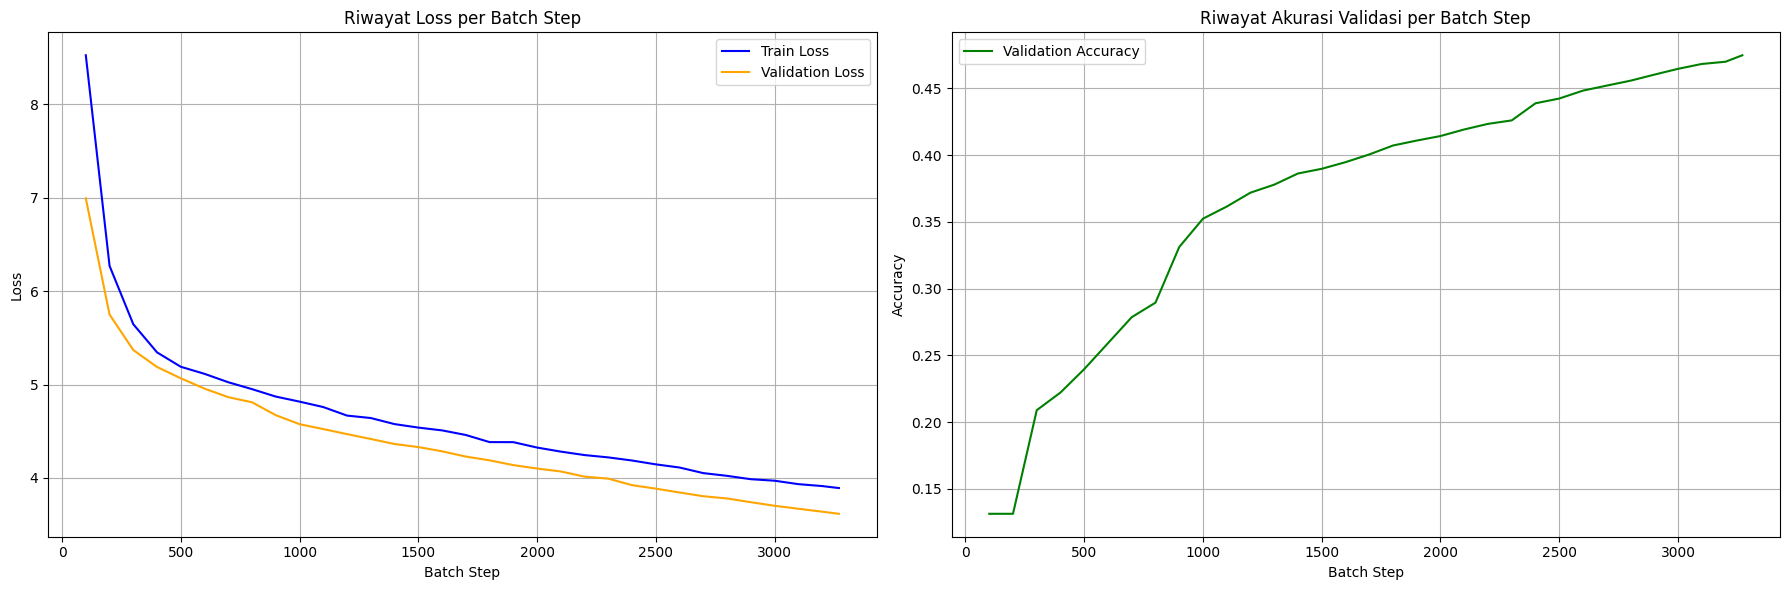

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

try:
    if not history or not history['batch_step']:
        print("Error: Variabel 'history' kosong.")
        print("Pastikan Anda sudah menjalankan 'BLOK 5 (Perbaikan)' terlebih dahulu.")
    else:
        # Buat DataFrame dari riwayat
        df_history = pd.DataFrame(history)

        # Buat 2 subplot (1 baris, 2 kolom)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

        # --- Plot 1: Grafik Loss (Train vs Val) ---
        ax1.plot(df_history['batch_step'], df_history['train_loss'], label='Train Loss', color='blue')
        ax1.plot(df_history['batch_step'], df_history['val_loss'], label='Validation Loss', color='orange')
        ax1.set_title('Riwayat Loss per Batch Step')
        ax1.set_xlabel('Batch Step')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # --- Plot 2: Grafik Akurasi (Val) ---
        ax2.plot(df_history['batch_step'], df_history['val_acc'], label='Validation Accuracy', color='green')
        ax2.set_title('Riwayat Akurasi Validasi per Batch Step')
        ax2.set_xlabel('Batch Step')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)

        # Tampilkan kedua grafik
        plt.tight_layout()
        plt.show()

except NameError:
    print("Error: Variabel 'history' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan 'BLOK 5 (Perbaikan)' terlebih dahulu.")

### 8. Inferensi Model (Penerapan)

#### 8.1 Memuat Model

* **`inference_model = Transformer(...)`**: Membuat sebuah *instance* baru dari kelas `Transformer`.
* **`inference_model.load_state_dict(...)`**: Mengambil semua bobot (weights) yang telah dilatih dan disimpan dalam file `transformer_eng_ru_final.pth` dan memuatnya ke dalam arsitektur `inference_model` yang dibuat.
* **`inference_model.eval()`**: Mengubah model ke "mode evaluasi", yang secara otomatis menonaktifkan lapisan-lapisan yang hanya digunakan untuk *training*, seperti `Dropout`.

#### 8.2 Fungsi Inferensi (`translate_sentence`)

* **Langkah 1: Tokenisasi Input**
   * Kalimat bahasa Inggris (string) diubah menjadi token, lalu dikonversi menjadi indeks numerik dari `vocab_en`, dan dibungkus dengan token `SOS_IDX` dan `EOS_IDX`.

* **Langkah 2: Buat Tensor & Mask Encoder**
    * Tensor input dan *padding mask* (topeng) yang sesuai disiapkan untuk *encoder*.

* **Langkah 3: Jalankan Encoder (Satu Kali)**
    * `with torch.no_grad()`: Menonaktifkan perhitungan gradien.
    * `encoder_output = model.encoder(...)`: Kalimat sumber dijalankan melalui *encoder* hanya satu kali. Hasilnya (`encoder_output`) adalah representasi kontekstual dari kalimat sumber yang akan digunakan oleh *decoder* di setiap langkah.

* **Langkah 4: Loop Decoder**
    1.  `trg_indices = [SOS_IDX]`: Proses *decoding* dimulai hanya dengan token `<sos>`.
    2.  `for i in range(max_len)`: *Loop* dimulai untuk menghasilkan kata satu per satu.
    3.  `trg_tensor = ...`: Tensor target dibuat dari *list* `trg_indices` (yang awalnya hanya `[<sos>]`).
    4.  `trg_mask = ...`: *Mask* *look-ahead* dibuat untuk tensor target saat ini, memastikan *decoder* hanya dapat melihat token-token sebelumnya.
    5.  `output = model.decoder(...)`: *Decoder* dijalankan satu kali, mengambil `encoder_output` dan *output* parsial sejauh ini (`trg_tensor`).
    6.  `logits = model.fc_output(output[:, -1, :])`: Mengambil *output* dari **token terakhir** (`output[:, -1, :]`) dan melemparkannya ke lapisan `Linear` akhir untuk mendapatkan prediksi kata berikutnya.
    7.  `pred_token = logits.argmax(1).item()`: Melakukan "Greedy Search" dengan memilih satu kata (indeks) dengan probabilitas tertinggi sebagai prediksi berikutnya.
    8.  `trg_indices.append(pred_token)`: Token yang diprediksi ditambahkan kembali ke *list* `trg_indices`.
    9.  `if pred_token == EOS_IDX: break`: *Loop* berhenti jika model memprediksi token `<eos>` (akhir kalimat).

* **Langkah 5: Konversi Output ke Teks**
    * `trg_tokens = [vocab_ru.lookup_token(i) ... ]`: *List* indeks target yang sudah selesai (misal: `[2, 9, 3]`) dikonversi kembali menjadi kata-kata menggunakan `vocab_ru` (misal: `['<sos>', 'привет', '<eos>']`).
    * `return " ".join(...)`: Hasil terjemahan dikembalikan sebagai *string*, dengan token `<sos>` dan `<eos>` dihilangkan.

In [27]:
print("Memuat model dari file...")
inference_model = Transformer(
    dimensi_embedding=DIMENSI_EMBEDDING,
    ukuran_sumber_vocab=UKURAN_SUMBER_VOCAB,
    ukuran_target_vocab=UKURAN_TARGET_VOCAB,
    panjang_sekuens=PANJANG_MAKS_SEKUENS,
    jumlah_block=JUMLAH_BLOCK,
    faktor_ekspansi=FAKTOR_EKSPANSI,
    heads=HEADS,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
).to(DEVICE)

try:
    inference_model.load_state_dict(torch.load('transformer_eng_ru_final.pth'))
except FileNotFoundError:
    print("Error: File 'transformer_eng_ru_final.pth' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan Blok 5 (Training) sampai selesai.")

inference_model.eval()

print("Model berhasil dimuat dan diatur ke mode evaluasi.")

def translate_sentence(
    model,
    sentence: str,
    vocab_en: CustomVocab,
    vocab_ru: CustomVocab,
    tokenizer_en,
    device,
    max_len: int = 50
):

    model.eval()

    tokens = [tok.lower() for tok in tokenizer_en(sentence)]
    src_indices = [SOS_IDX] + [vocab_en[token] for token in tokens] + [EOS_IDX]

    src_tensor = torch.tensor(src_indices).unsqueeze(0).to(device)
    src_mask = model.buat_padding_mask(src_tensor)

    with torch.no_grad():
        encoder_output = model.encoder(src_tensor, src_mask)

    trg_indices = [SOS_IDX] # Mulai output dengan token <sos>

    for i in range(max_len):
        # Buat tensor target dari token yang sudah diprediksi
        trg_tensor = torch.tensor(trg_indices).unsqueeze(0).to(device)

        # Buat mask untuk decoder
        trg_padding_mask = model.buat_padding_mask(trg_tensor)
        trg_look_ahead_mask = model.buat_look_ahead_mask(trg_tensor)
        trg_mask = trg_padding_mask & trg_look_ahead_mask

        # Jalankan decoder dengan output encoder
        with torch.no_grad():
            output = model.decoder(trg_tensor, encoder_output, trg_mask, src_mask)

        # Ambil prediksi HANYA untuk token terakhir
        logits = model.fc_output(output[:, -1, :])
        pred_token = logits.argmax(1).item()

        # Tambahkan prediksi ke daftar
        trg_indices.append(pred_token)

        # Hentikan jika model memprediksi <eos>
        if pred_token == EOS_IDX:
            break

    trg_tokens = [vocab_ru.lookup_token(i) for i in trg_indices]

    return " ".join(trg_tokens[1:-1])

Memuat model dari file...
Model berhasil dimuat dan diatur ke mode evaluasi.


### 9. Menjalankan Inferensi (Contoh Penerapan)

* Blok ini mendefinisikan tiga kalimat sumber baru dalam bahasa Inggris (`kalimat_1`, `kalimat_2`, `kalimat_3`).
* Fungsi `translate_sentence` dipanggil secara berurutan untuk setiap kalimat. Fungsi ini menerima semua komponen yang diperlukan:
    * `inference_model`: Model Transformer yang sudah dilatih dan dimuat ke mode `.eval()`.
    * `vocab_en`, `vocab_ru`: Kosakata yang diperlukan untuk konversi teks-ke-indeks dan sebaliknya.
    * `tokenize_en`: Tokenizer Spacy untuk memecah kalimat input.
    * `DEVICE`: GPU (`cuda`) atau CPU.
* `print` digunakan untuk menampilkan perbandingan berdampingan antara kalimat asli (Source EN) dan hasil terjemahan model (Model RU).

In [28]:
kalimat_1 = "Hi, Friends"
kalimat_2 = "How Are You?"
kalimat_3 = "I Love You"

translation_1 = translate_sentence(
    inference_model,
    kalimat_1,
    vocab_en,
    vocab_ru,
    tokenize_en,
    DEVICE
)
print(f"Source (EN): {kalimat_1}")
print(f"Model (RU): {translation_1}\n")

translation_2 = translate_sentence(
    inference_model,
    kalimat_2,
    vocab_en,
    vocab_ru,
    tokenize_en,
    DEVICE
)
print(f"Source (EN): {kalimat_2}")
print(f"Model (RU): {translation_2}\n")

translation_3 = translate_sentence(
    inference_model,
    kalimat_3,
    vocab_en,
    vocab_ru,
    tokenize_en,
    DEVICE
)
print(f"Source (EN): {kalimat_3}")
print(f"Model (RU): {translation_3}\n")

Source (EN): Hi, Friends
Model (RU): пожалуйста <unk> .

Source (EN): How Are You?
Model (RU): как ты ?

Source (EN): I Love You
Model (RU): я не тебя .

